In [1]:
import pandas as pd
import numpy as np

train_data = pd.read_excel("Data/tr.xlsx",)

In [2]:
over_missing_sample = []
row_value_count = train_data.apply(pd.Series.value_counts,axis=1,dropna=False)

In [3]:
import tools
#Data transform
train_y = pd.DataFrame(train_data['outcome']) 
train_X = pd.DataFrame(train_data.drop(['outcome'],axis=1))

train_X = tools.data_transform(train_X)

In [4]:
import tools
tools.set_pandas_display_options()
#train_X.describe()

In [5]:
threshhold =len(train_X.columns)*0.25
over_missing = row_value_count[np.nan]<=threshhold
class_0 = train_y['outcome']==1

print(sorted(train_y.value_counts()))
train_X = train_X[over_missing|class_0]
train_y = train_y[over_missing|class_0]
print(sorted(train_y.value_counts()))


[879, 51280]
[879, 27076]


In [6]:
# Data split
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(
    train_X ,
    train_y,
    test_size=0.2,
    random_state=42)

print(sorted(train_y.value_counts()))
print(sorted(val_y.value_counts()))

[718, 21646]
[161, 5430]


In [7]:
# Missing value imputation
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tools
feature_kind = tools.init_feature_kind(train_X)
cont,cate = tools.get_feature_kind(train_X,feature_kind)  

strategy = 'median'

imp_mean = IterativeImputer(max_iter=100,random_state=0)
imp_mean.fit(train_X[cont])

train_X[cont] = imp_mean.transform(train_X[cont])
val_X[cont] = imp_mean.transform(val_X[cont])

print("filled continuous missing value with "+strategy)

strategy = 'constant'

imp = SimpleImputer(missing_values=np.nan, strategy=strategy,fill_value=10.0)
imp.fit(train_X[cate])

train_X[cate] = imp.transform(train_X[cate])
val_X[cate] = imp.transform(val_X[cate])


print("filled nominal missing value with ",strategy)


filled continuous missing value with median
filled nominal missing value with  constant


In [8]:
from sklearn import preprocessing


cont,cate = tools.get_feature_kind(train_X,feature_kind)

scaler = preprocessing.StandardScaler().fit(train_X[cont])
train_X[cont] = scaler.transform(train_X[cont])
val_X[cont] = scaler.transform(val_X[cont])

In [9]:
from sklearn.preprocessing import OneHotEncoder


end =OneHotEncoder()
onehot_train_X = pd.DataFrame(end.fit_transform(train_X[cate]).toarray())
onehot_val_X = pd.DataFrame(end.transform(val_X[cate]).toarray())

train_X = train_X.reset_index(drop=True)
val_X = val_X.reset_index(drop=True)

train_X = pd.concat([train_X[cont],onehot_train_X],axis=1,ignore_index=True)
val_X = pd.concat([val_X[cont],onehot_val_X],axis=1,ignore_index=True)

In [10]:
def y_onehot(y):
    mapped = []
    
    for ind,lab in y.iterrows():
        if(lab[0]==0):
            mapped.append([1,0])
        elif(lab[0]==1):
            mapped.append([0,1])
        else:
            print(lab)
            print('error')
    return mapped
map_train_y = y_onehot(train_y)
map_val_y = y_onehot(val_y)

In [11]:
from torch.utils.data import DataLoader, Dataset
class TrainDataset(Dataset):
    def __init__(self,X,y) -> None:
        super().__init__()
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, index) :
        return torch.tensor(self.X.iloc[index]).to(device),torch.tensor(self.y[index]).to(device)

In [12]:
from torch.utils.data import dataloader
import torch

device = torch.device('cuda')

train_dataset = TrainDataset(train_X,map_train_y)
val_dataset = TrainDataset(val_X,map_val_y)





In [13]:
from torch.utils.data.sampler import WeightedRandomSampler
def balance_prob(y):
    print(y.value_counts())
    prob = 1/y.value_counts()
    print(prob)
    dataset_element_weights = [] # each element prob
    for label_id in y:                
        dataset_element_weights.append(prob[label_id])
    return dataset_element_weights

balance_prob = balance_prob(train_y['outcome'])
sampler = WeightedRandomSampler(weights=balance_prob,num_samples=len(map_train_y),replacement=True)

0    21646
1      718
Name: outcome, dtype: int64
0    0.000046
1    0.001393
Name: outcome, dtype: float64


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# Create CNN Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.line1 = nn.Linear(124,64)
        self.line2 = nn.Linear(64,16)
        self.line3 = nn.Linear(16,2)
        self.sig = nn.Sigmoid()
    
    def forward(self, x):
        out = self.line1(x)
        out = self.sig(out)
        out = self.line2(out)
        out = self.sig(out)
        out = self.line3(out)
        out = F.softmax(out,1)
        return out

In [33]:
from torch.utils.data import WeightedRandomSampler

import torch.nn as nn
# Hyper parm
# batch_size, epoch and iteration
batch_size = 100
n_iters = 11000
num_epochs = 50
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, sampler=sampler)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False)


model = Net()
model.to(device)
# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters())
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)

In [34]:
from torch.autograd import Variable
# ANN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

model.train()
performace = {}


for epoch in range(num_epochs):
    for i, (X, y) in enumerate(train_loader):
        

        optimizer.zero_grad() # Clear gradients
        outputs = model(Variable(X.float().to(device))) # Forward propagation
        #print(outputs)
       # print(y.float())
        #print(outputs)
        loss = error(outputs,y.float()) # Calculate softmax and cross entropy loss
        loss.backward() # Calculating gradients
        optimizer.step() # Update parameters
       
        count += 1
        
        if count%100 == 0:
            # Calculate Accuracy         
            predict = []
            true = []
            model.eval()
            # Predict val dataset
            for X, y in val_loader:
                #print(X.float())
                outputs = model(X.float()) # Forward propagation
                val_loss = error(outputs,y.float())
                outputs = outputs.cpu().detach().numpy()
                y = y.cpu().detach().numpy()
                
                for pred in outputs:
                    predict.append(np.argmax(pred))
                for label in y:
                    true.append(np.argmax(label))
                
            #print(true)
           # print(predict)
            performace[count] = (tools.get_performance(true,predict))
            
            
            print("iter:",count,"train loss:",loss.data.item(),"val_loss:",val_loss.data.item())
            print("val")
            print("f1_score:",performace[count]['f1_score'],'confusion matrix:\n',performace[count]['confusion matrix'])
            print()
            performace[count]['train_loss'] = loss.data.item()
            performace[count]['val_loss'] = val_loss.data.item()
                
                
            model.train()
    
        


iter: 100 train loss: 0.6849669218063354 val_loss: 0.661651611328125
val
f1_score: 0.0817382307294361 confusion matrix:
 [[3737 1693]
 [  82   79]]

iter: 200 train loss: 0.6249690651893616 val_loss: 0.6531534194946289
val
f1_score: 0.08967032967032969 confusion matrix:
 [[3418 2012]
 [  59  102]]

iter: 300 train loss: 0.6109700798988342 val_loss: 0.6539039015769958
val
f1_score: 0.09198312236286918 confusion matrix:
 [[3330 2100]
 [  52  109]]

iter: 400 train loss: 0.593670666217804 val_loss: 0.6437085270881653
val
f1_score: 0.09196390201976795 confusion matrix:
 [[3371 2059]
 [  54  107]]

iter: 500 train loss: 0.5789493918418884 val_loss: 0.6245673894882202
val
f1_score: 0.10146252285191955 confusion matrix:
 [[3514 1916]
 [  50  111]]

iter: 600 train loss: 0.5764856338500977 val_loss: 0.5875203013420105
val
f1_score: 0.11542497376705142 confusion matrix:
 [[3795 1635]
 [  51  110]]

iter: 700 train loss: 0.5607256293296814 val_loss: 0.586861789226532
val
f1_score: 0.124746450304

<AxesSubplot:>

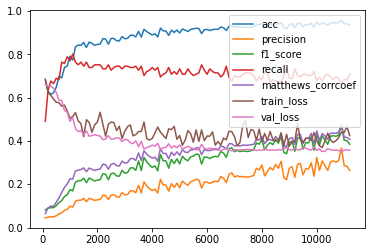

In [35]:
#print(pd.DataFrame(performace).T)    
pd.DataFrame(performace).T.plot()

In [36]:
torch.save(model.state_dict(), 'ANNweight')

In [37]:
final_performance = {}
predict = []
true = []
model.eval()
for X, y in val_loader:
    #print(X.float())
    outputs = model(X.float()) # Forward propagation
    val_loss = error(outputs,y.float())
    outputs = outputs.cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    
    for pred in outputs:
        predict.append(np.argmax(pred))
    for label in y:
        true.append(np.argmax(label))
final_performance['val'] = tools.get_performance(true,predict)
predict = []
true = []
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size)

for X, y in train_loader:
    #print(X.float())
    outputs = model(X.float()) # Forward propagation
    val_loss = error(outputs,y.float())
    outputs = outputs.cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    
    for pred in outputs:
        predict.append(np.argmax(pred))
    for label in y:
        true.append(np.argmax(label))
final_performance['train'] = tools.get_performance(true,predict)

In [38]:
pd.DataFrame(final_performance)

,val,train
confusion matrix,"[[5113, 317], [47, 114]]","[[20748, 898], [104, 614]]"
acc,0.934895,0.955196
precision,0.264501,0.406085
f1_score,0.385135,0.550673
recall,0.708075,0.855153
matthews_corrcoef,0.407342,0.571279
